## Using Computer Vision Model for tampered image detection

In this lab, we will use a dedicated computer vision model which detect tampered images. The model will predict whether input model was forged one based on a trained Convolutional Neural Network (CNN) model. This approach was published as a [AWS Blog](https://aws.amazon.com/blogs/machine-learning/train-and-host-a-computer-vision-model-for-tampering-detection-on-amazon-sagemaker-part-2/).
<br/>
This lab will be executed in two parts:
1. Train a CNN model with training dataset(images).
2. Create an agent who will delegate the fraud image detection to the model.



## Step 1: Clone the ML model code from GitHub and deploy it

In [ ]:
!pip install pillow  strands-agents==1.0.0 strands-agents-tools==0.2.1
!git clone https://github.com/aws-solutions-library-samples/guidance-for-fraud-detection-with-intelligent-document-processing-on-aws.git tamered-image-detection

In [ ]:
!cd ./tamered-image-detection/sagemaker/document-tampering-detection/ &&  python train_and_deploy.py

#### Now we have a SageMaker endpoint with a CNN model which detects tampered images

Now let us test the model. Firstly, let us compare a tampered images vs its original.

#### A tampered image vs the original image: Can you tell the differences?
##### [Tampered image]: TamperedPaystub_0.jpg
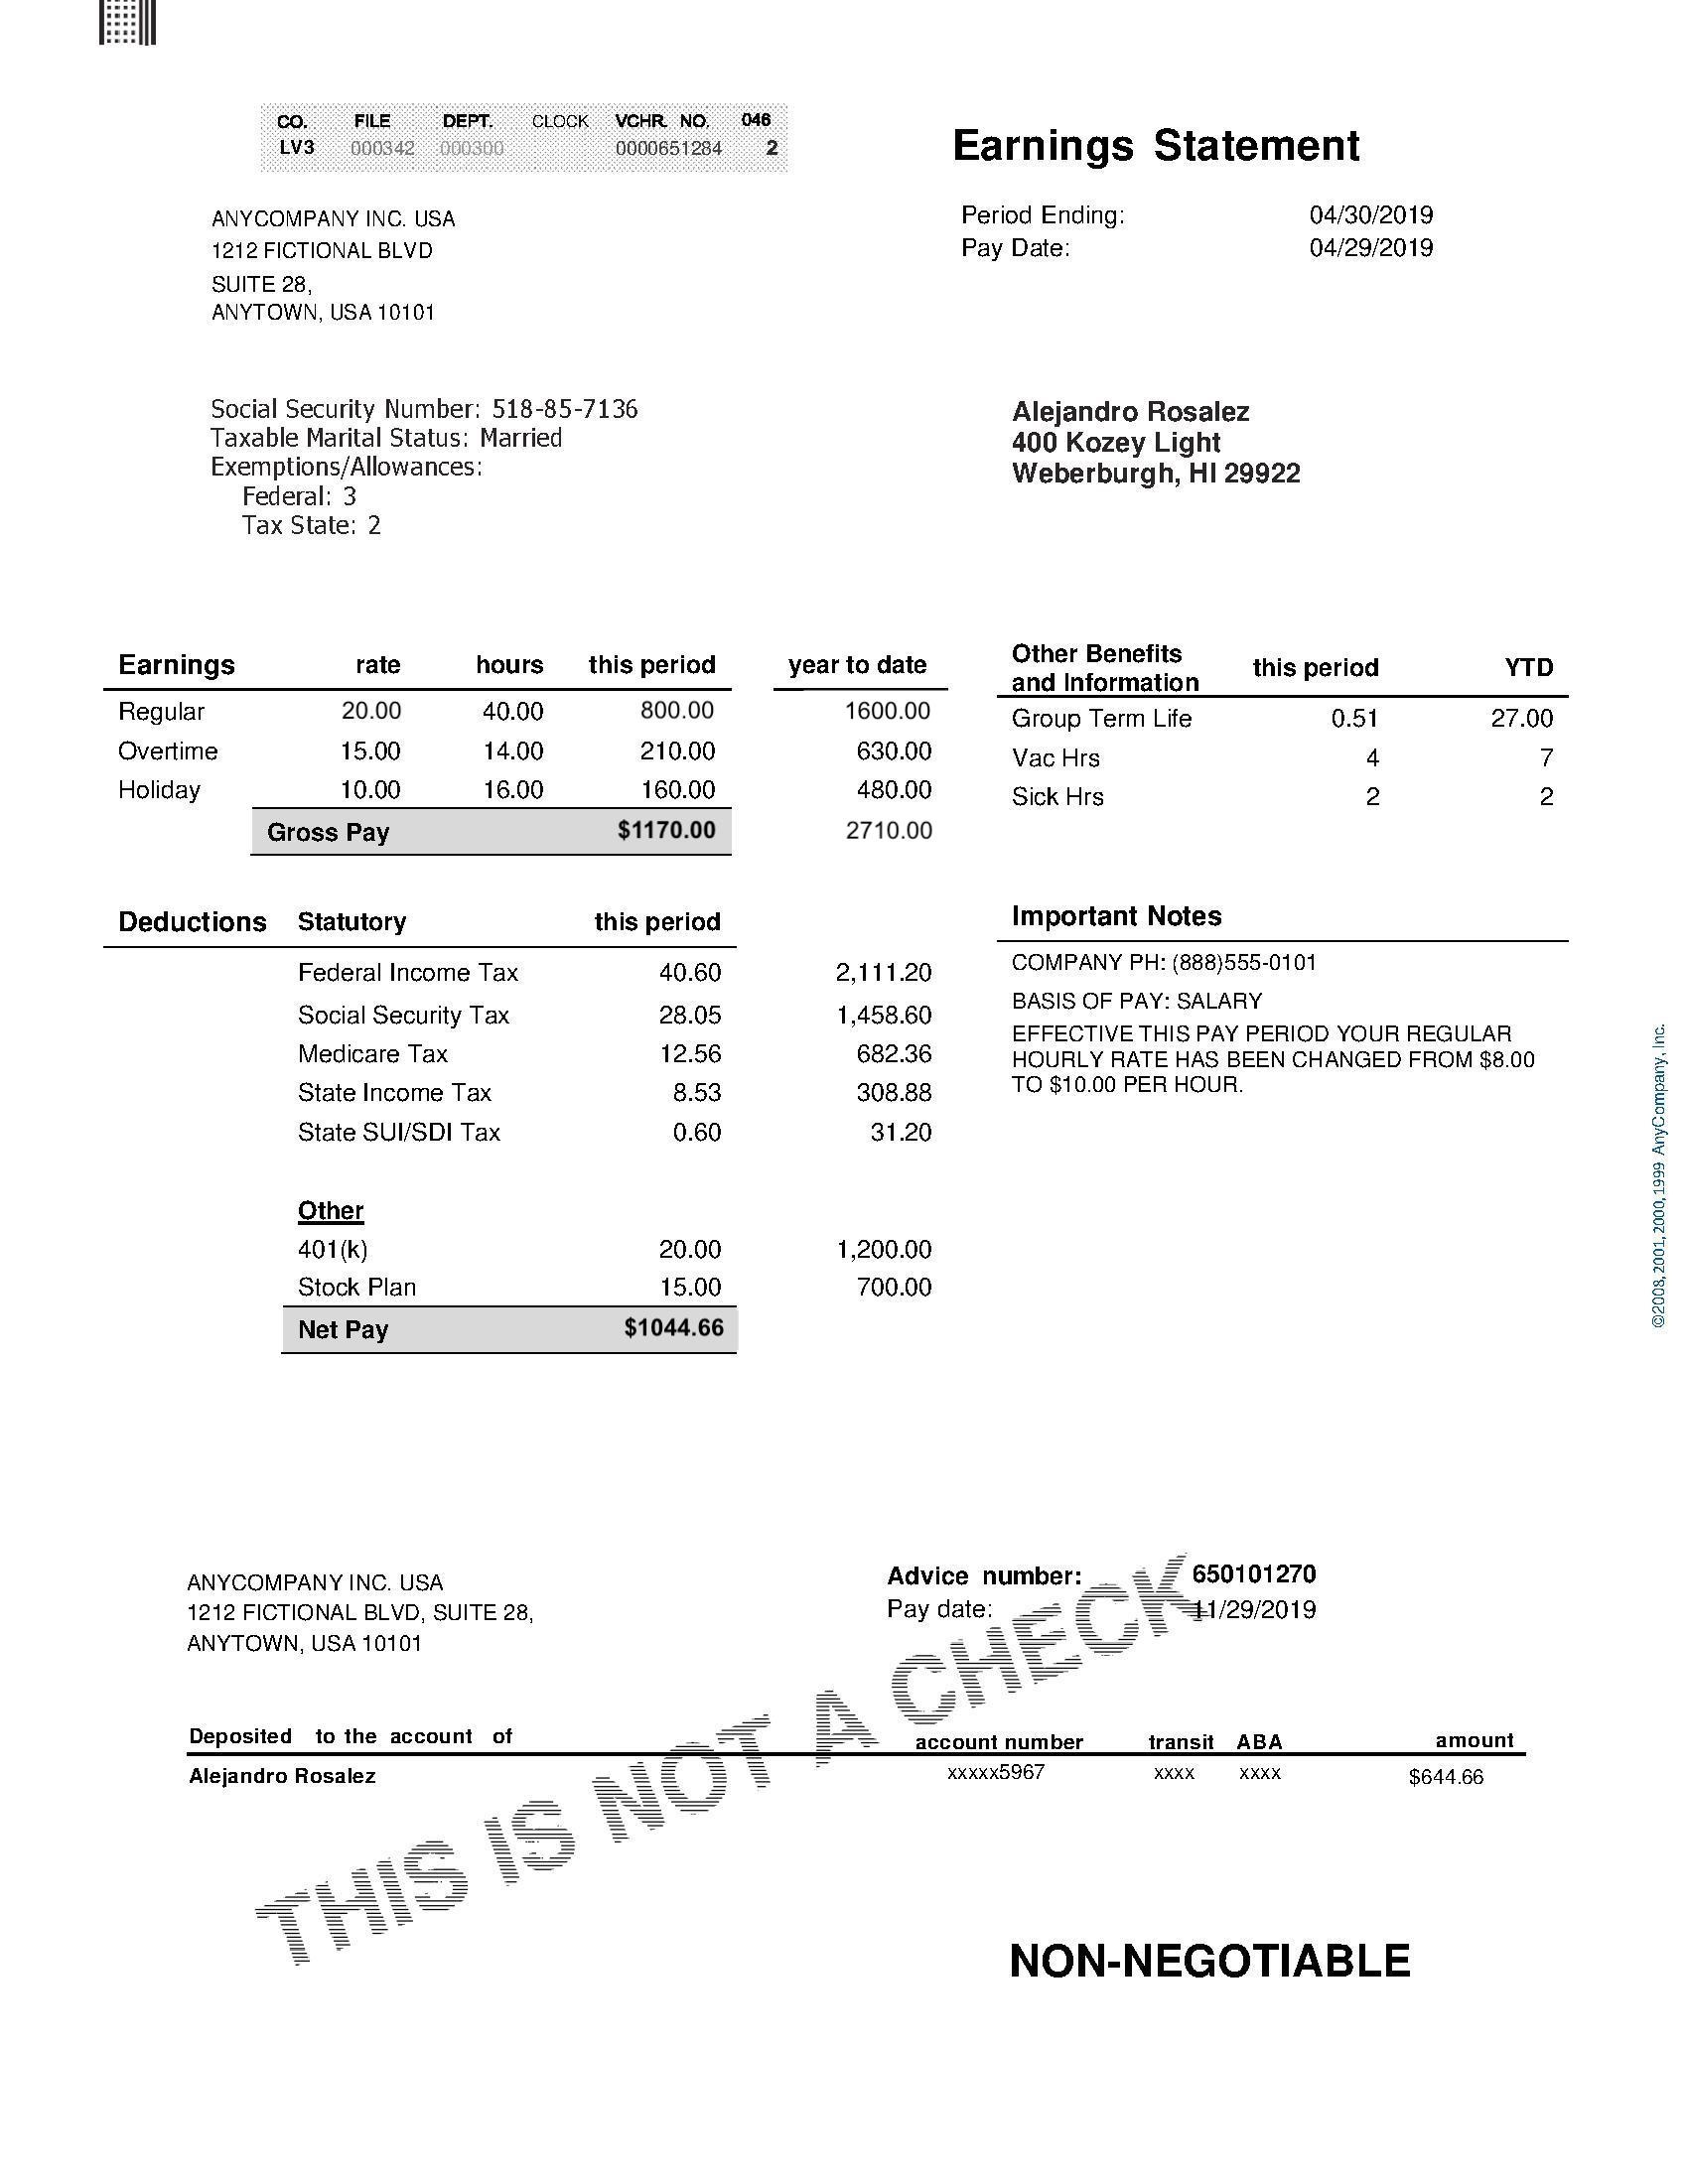
##### [Original image]: Paystub_0.jpg
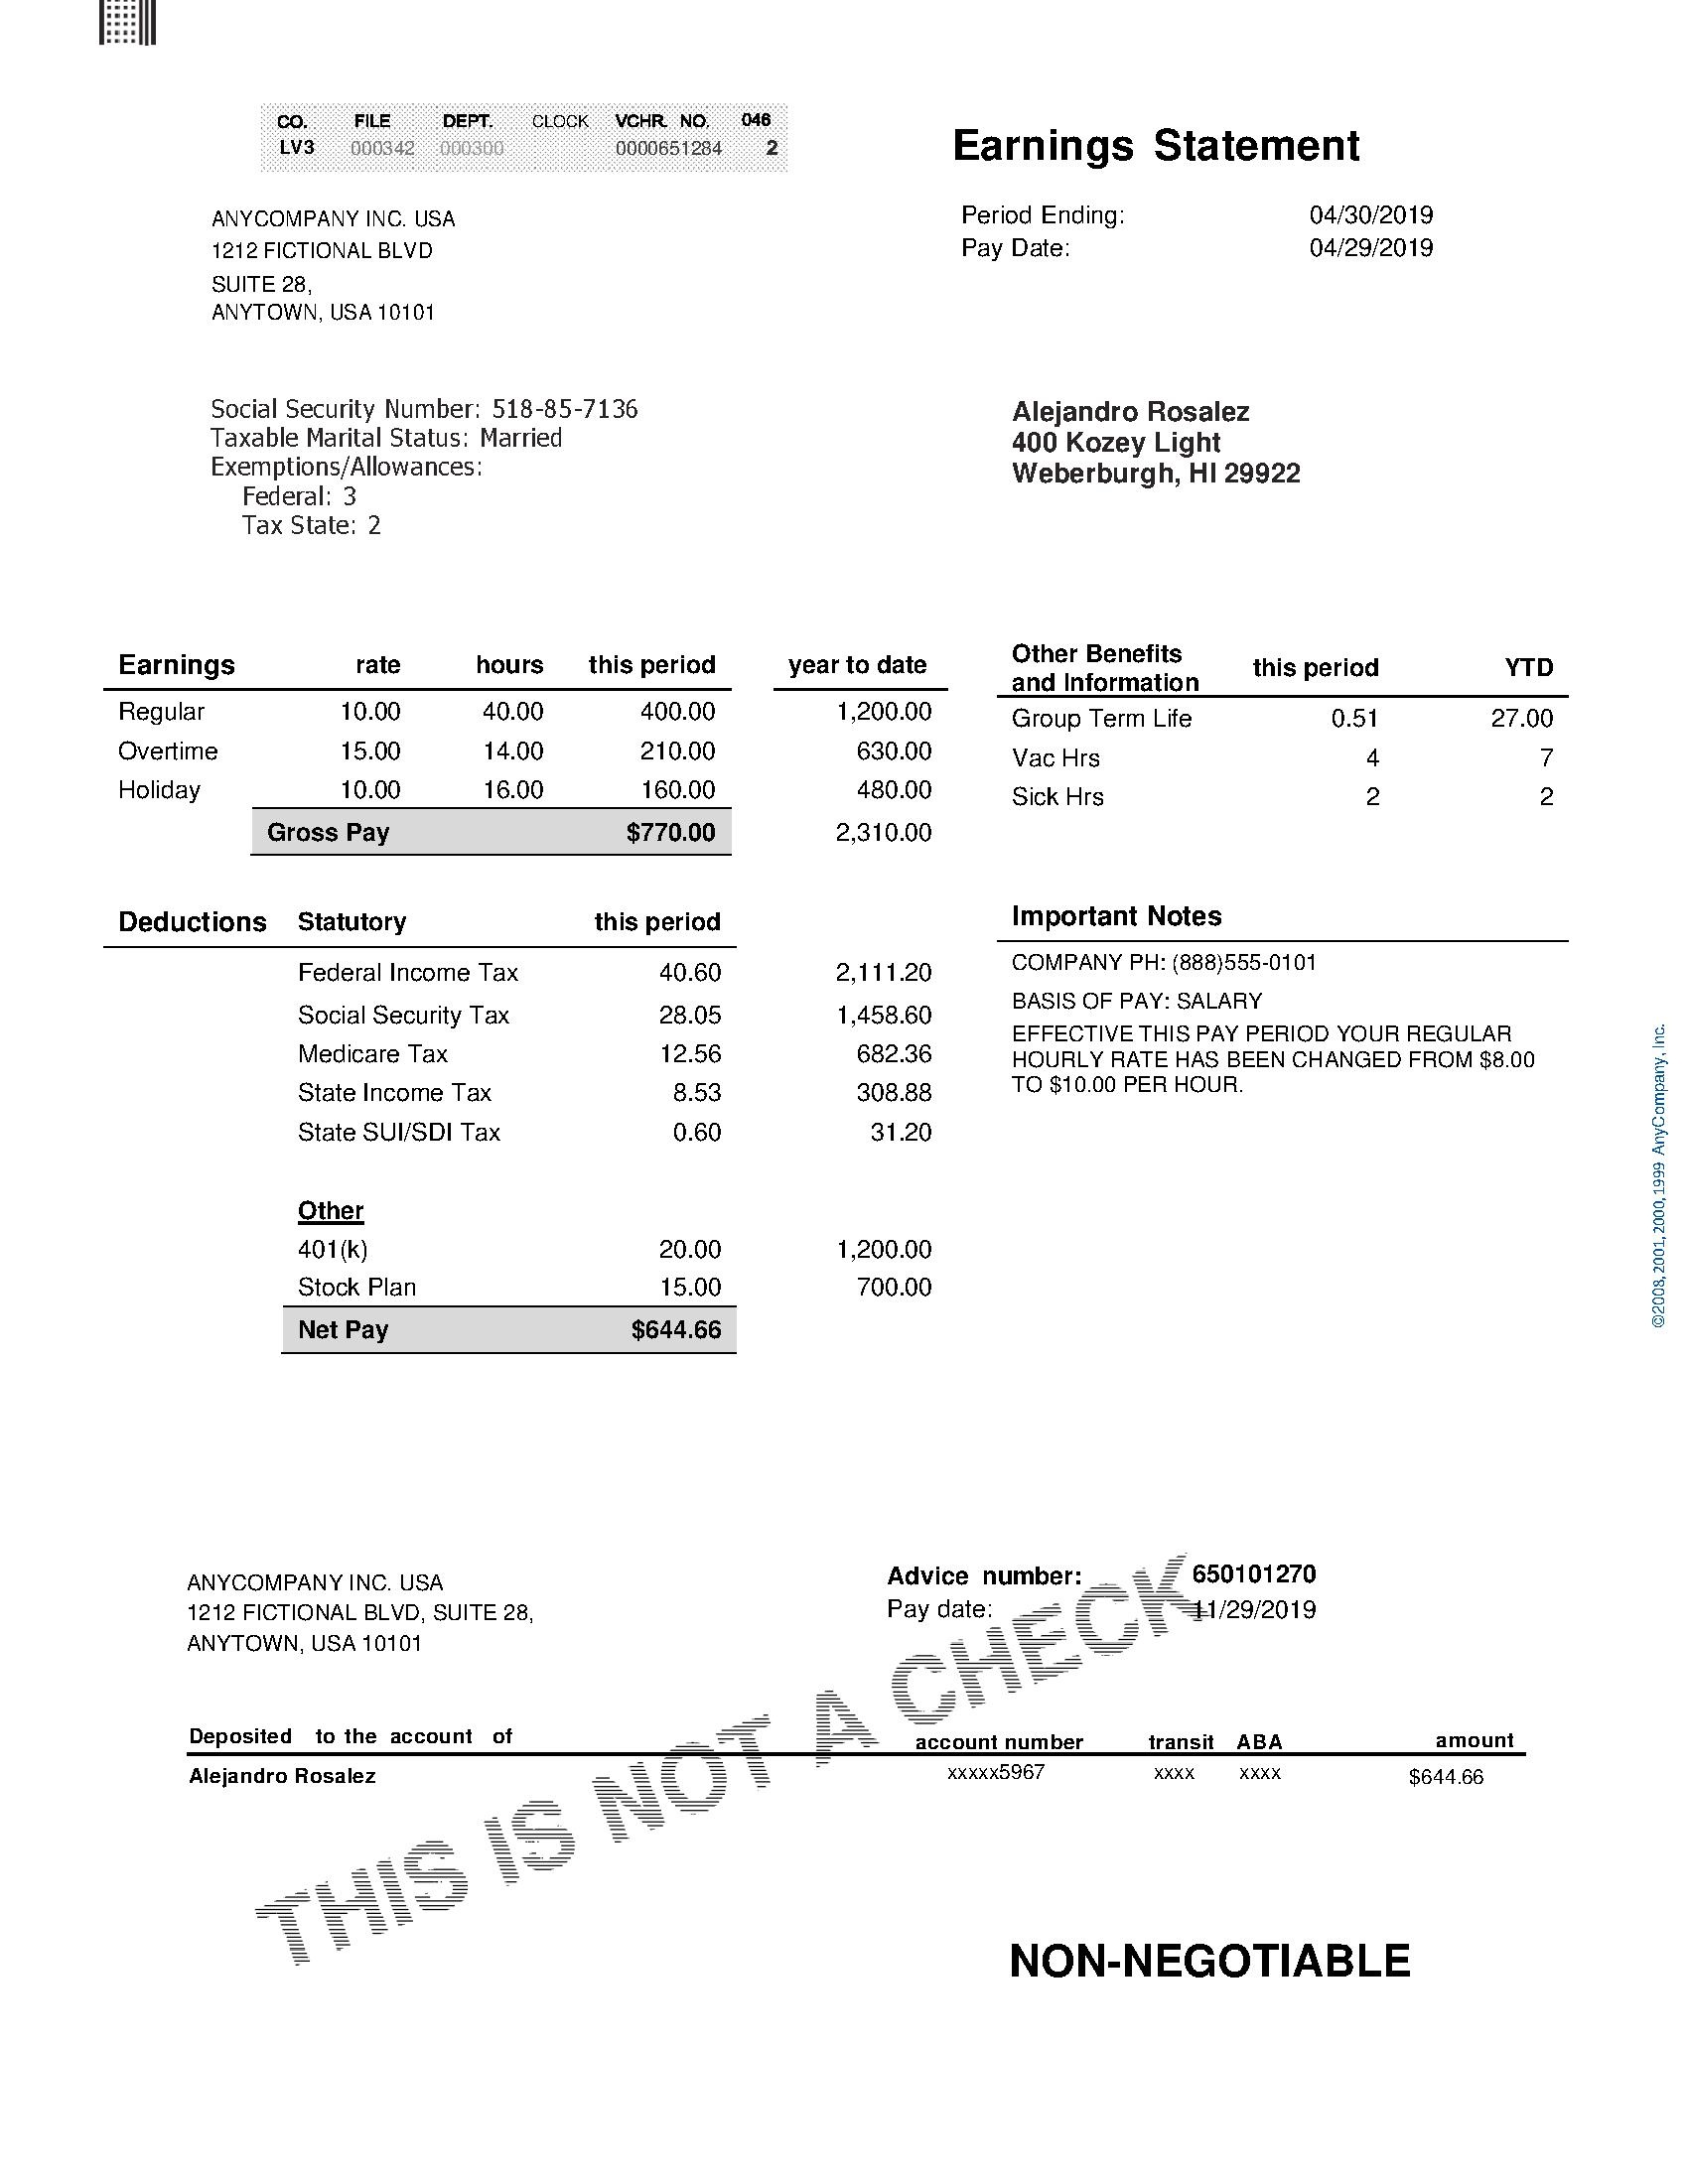

Let us try the deployed model. 

In [ ]:
from tampered_image_detection import check_image
from IPython.display import Image, display

images = [
    "./images/Paystub_0.jpg",  # Original
    "./images/TamperedPaystub_0.jpg" # Tampered
]

# Invoke the endpoint to validate the images
for i in images:
    response = check_image(i, "document-tampering-detection-v-DEMO")
    print(f"{i} is{' NOT' if not response else ''} a forged image") 


### Step 2: Combine the ML model with an agentic workflow

In [ ]:
# Define a tool to invoke the ML model
from strands import Agent, tool
from tampered_image_detection import check_image
from IPython.display import display, Markdown

@tool
def detect_tampered_image(image_path: str) -> str:
    """
    Detect if the input image is a forged one or not.
    Args:
    image_path(str): A local path to the image file.

    Return (str): "tampered" if the image is a forged one, "original" if not.
    """
    response = check_image(image_path, "document-tampering-detection-v-DEMO")
    
    return "tampered" if response else "original"
    

agent = Agent(
    model="us.anthropic.claude-3-7-sonnet-20250219-v1:0",
    system_prompt="You are a fraud detector for mortage files processing."
              "Detect if uploaded image files were forged one or not.",
    tools = [detect_tampered_image])

response = agent(
    "We are processing a new morgagage application. A customer sent two paystubs for thier proof of income."
    "Please process the scanned files"
    ""
    "images/Paystub_0.jpg"
    "images/TamperedPaystub_0.jpg"
)
